In [1]:
!bash sciunit_fix.sh

Uninstalling sciunit-0.2:
  Successfully uninstalled sciunit-0.2
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/scidash/sciunit (to dev) to /tmp/pip-ca0ouk2k-build
  Running setup.py install for sciunit ... - done
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fatal: destination path 'AllenInstituteNeuroML' already exists and is not an empty directory.
  Cloning https://github.com/OpenSourceBrain/OpenCortex (to dev) to /tmp/pip-v6bqcwke-build
  Could not find a tag or branch 'dev', assuming commit.
error: pathspec 'dev' did not match any file(s) known to git.
Command "git checkout -q dev" failed with error code 1 in /tmp/pip-v6bqcwke-build
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --up


# Assumptions about this code:
The NB was launched with a command that mounts two volumes inside a docker container. 
In the future invocation of this script will be simplified greatly. NU is from a specific fork and branch -b results https://github.com/russelljjarvis/neuronunit 
BluePyOpt is also from a specific fork and branch: -b elitism https://github.com/russelljjarvis/BluePyOpt

Below BASH code for Ubuntu host:

``` bash
cd ~/git/neuronunit; sudo docker run -it -v `pwd`:/home/jovyan/neuronunit -v ~/git/BluePyOpt:/home/jovyan/BluePyOpt neuronunit-optimization /bin/bash'
```

## Parallel Environment.
Parallelisation module: dask distributed.

In [2]:
import os
os.system('jupyter trust test_ga_versus_grid.ipynb'); #suppress the untrusted notebook warning.



In [3]:
import pickle
with open('dump_all_cells','rb') as f:
   pipe_results = pickle.load(f)
print(pipe_results)

{'830368389': {'history': <deap.tools.support.History object at 0x7fb55da00a58>, 'hof_py': <deap.tools.support.HallOfFame object at 0x7fb5730f3ac8>, 'pop': [[0.00010821973620985332, 0.090007907214554594, -58.179186826126831, -73.598616612150579, -4.1604158856079779e-09, -61.286196326503116, 0.00075848843197318333, 0.75726110392930013, 35.068721342349846, -44.178156326585992], [9.0480745623745093e-05, 0.12280205502157669, -55.965241246048237, -60.563270960756007, -4.8085275382009239e-09, -53.40993643669885, 0.00067905747414705739, 0.71592663632057807, 33.445699624181898, -39.715266444569124], [9.0136678171788209e-05, 0.11893423915147662, -55.30425418610745, -63.563872869353631, -4.7229249986774164e-09, -65.155281770002233, 0.00064279861626438391, 0.33073648137283396, 34.53391304172343, -48.955275754007118], [9.0136678171788209e-05, 0.11893423915147662, -55.30425418610745, -63.563872869353631, -4.7229249986774164e-09, -65.155281770002233, 0.00064279861626438391, 0.33073648137283396, 34.5

In [5]:
import pandas as pd
for index, val in enumerate(pipe_results.values()):
    if index == 0:
        sci = pd.DataFrame(list(val['pop'][0].dtc.scores.values())).T
    else:    
        sci = sci.append(pd.DataFrame(list(val['pop'][0].dtc.scores.values())).T)
        
#sci.columns = val['pop'][0].dtc.scores.keys()    
#print(sci)
sci

,0,1,2,3,4,5,6
0,0.957822,1.000000,0.999967,1.000000,0.374279,0.999759,0.395802
0,0.830968,1.000000,0.439508,1.000000,0.586374,0.541494,0.675278
0,0.957822,1.000000,0.999967,1.000000,0.374279,0.999759,0.395802
0,0.957822,1.000000,0.999967,1.000000,0.374279,0.999759,0.395802
0,1.000000,0.008952,1.000000,0.717591,0.977892,0.184814,NaN


In [6]:
import pandas as pd
for index, val in enumerate(pipe_results.values()):
    if index == 0:
        attrs = pd.DataFrame(list(val['pop'][0].dtc.attrs.values())).T
    else:    
        attrs = attrs.append(pd.DataFrame(list(val['pop'][0].dtc.attrs.values())).T)
        
attrs.columns = val['pop'][0].dtc.attrs.keys()    
#print(attrs)
attrs

,k,C,b,vt,d,c,v0,vr,a,vpeak
0,0.000758,0.000108,-4.160416e-09,-44.178156,0.090008,-58.179187,-73.598617,-61.286196,0.757261,35.068721
0,0.000832,0.000094,-4.040475e-09,-49.436928,0.155611,-58.842784,-59.076043,-61.815088,0.252952,38.127364
0,0.000758,0.000108,-4.160416e-09,-44.178156,0.090008,-58.179187,-73.598617,-61.286196,0.757261,35.068721
0,0.000758,0.000108,-4.160416e-09,-44.178156,0.090008,-58.179187,-73.598617,-61.286196,0.757261,35.068721
0,0.000657,0.000096,-3.736790e-09,-41.713720,0.138137,-55.587605,-49.614077,-60.274944,0.229389,37.974042


In [7]:
import pandas as pd
for index, val in enumerate(pipe_results.values()):
    if index == 0:
        rheobase = pd.DataFrame([i.dtc.rheobase for i in val['pop']]).T
    else:    
        rheobase = rheobase.append(pd.DataFrame([i.dtc.rheobase for i in val['pop']]).T)
        
#rheobase.columns = val['pop'][0].dtc.attrs.keys()    
#rheobase.index[0] = list(pipe_results.keys())[0]
#print(attrs)
rheobase
#pipe_results.keys()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
value,55.98958333333333 pA,32.55208333333333 pA,43.619791666666664 pA,43.619791666666664 pA,40.36458333333333 pA,32.55208333333333 pA,40.36458333333333 pA,14.322916666666666 pA,135.41666666666666 pA,52.73437499999999 pA,41.666666666666664 pA,147.13541666666666 pA,2.6041666666666665 pA,40.36458333333333 pA
value,32.55208333333333 pA,176.513671875 pA,13.020833333333332 pA,0.6510416666666666 pA,1.3020833333333333 pA,26.692708333333332 pA,176.513671875 pA,54.03645833333333 pA,112.46744791666666 pA,10.416666666666666 pA,20.182291666666664 pA,0.6510416666666666 pA,29.947916666666664 pA,176.513671875 pA
value,55.98958333333333 pA,32.55208333333333 pA,43.619791666666664 pA,43.619791666666664 pA,40.36458333333333 pA,32.55208333333333 pA,40.36458333333333 pA,14.322916666666666 pA,135.41666666666666 pA,52.73437499999999 pA,41.666666666666664 pA,147.13541666666666 pA,2.6041666666666665 pA,40.36458333333333 pA
value,55.98958333333333 pA,32.55208333333333 pA,43.619791666666664 pA,43.619791666666664 pA,40.36458333333333 pA,32.55208333333333 pA,40.36458333333333 pA,14.322916666666666 pA,135.41666666666666 pA,52.73437499999999 pA,41.666666666666664 pA,147.13541666666666 pA,2.6041666666666665 pA,40.36458333333333 pA
value,57.291666666666664 pA,109.375 pA,57.291666666666664 pA,262.20703125 pA,101.5625 pA,57.291666666666664 pA,57.291666666666664 pA,66.40625 pA,117.1875 pA,49.479166666666664 pA,260.7421875 pA,134.765625 pA,55.98958333333333 pA,55.98958333333333 pA


In [ ]:
import matplotlib
%matplotlib inline


################
# GA parameters:
about $10^{3}=30$ models will be made, excluding rheobase search.
################


# Choice of selection criteria is important. 
Here we use BluepyOpts IBEA, such that it can be compared to NSGA2.

https://link.springer.com/article/10.1007/s00500-005-0027-5




In [ ]:
MU = 6; NGEN = 6; CXPB = 0.9
USE_CACHED_GA = False

################
# Grid search parameters:
$ 2^{10}=1024 $ models, will be made excluding rheobase search
################

An oppurtunity to improve grid search, by increasing resolution of search intervals given a first pass:

In [ ]:
'''
opt_py = { k:hof_py[v] for v,k in enumerate(td_py) }
print(opt_fi)


for k,v in opt_py.items():
    print('param',k,v,opt_fi[k],'delta',abs(v-opt_fi[k]))
from neuronunit.optimization.optimization_management import write_opt_to_nml
fname = 'nifext_50'
write_opt_to_nml(fname, opt_py)
fname = 'NLXCELL_100201'
write_opt_to_nml(fname, opt_fi)
'''

In [9]:
from neuronunit.plottools import plot_surface


# Below two error surface slices from the hypervolume are plotted.
The data that is plotted consists of the error as experienced by the GA.
Note: the GA performs an incomplete, and efficient sampling of the parameter space, and therefore sample points are irregularly spaced. Polygon interpolation is used to visualize error gradients. Existing plotting code from the package BluePyOpt has been extended for this purpose.
Light blue dots indicate local minima's of error experienced by the NSGA algrorithm.

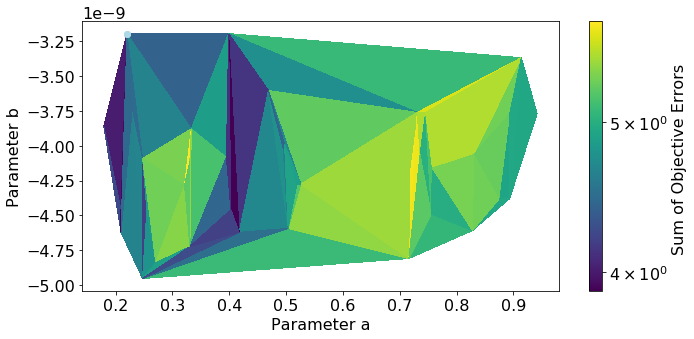

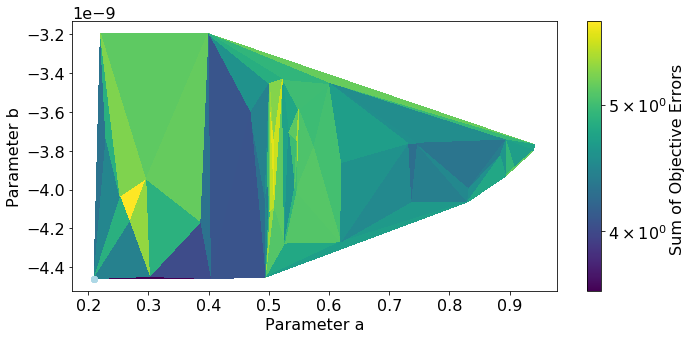

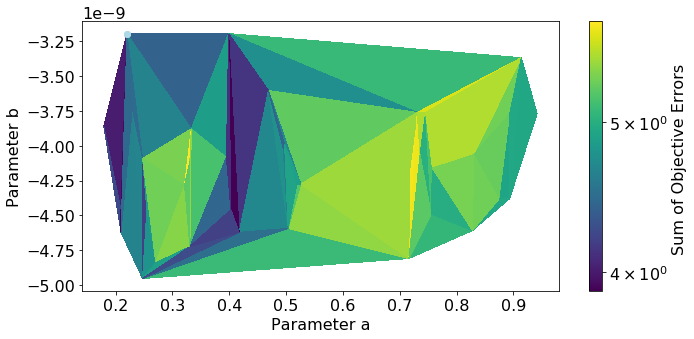

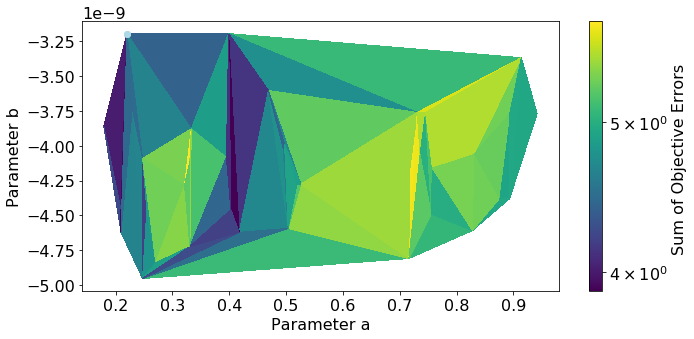

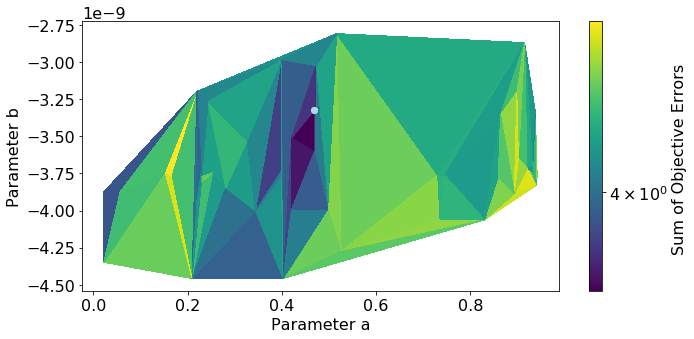

In [10]:
for index, val in enumerate(pipe_results.values()):
    td = val['td_py']
    history = val['history']

    plot_surface('a','b',td,history)

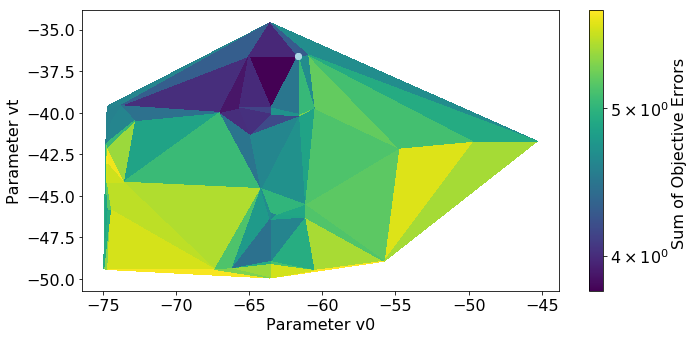

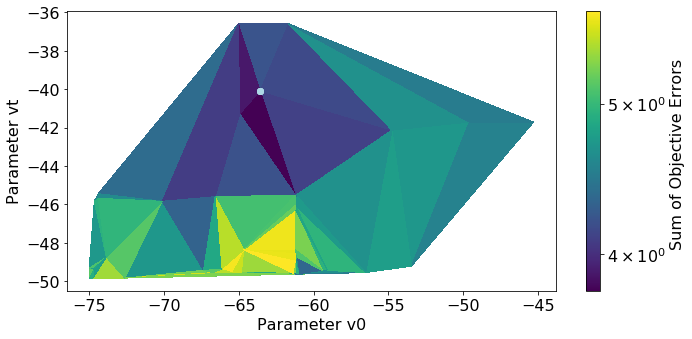

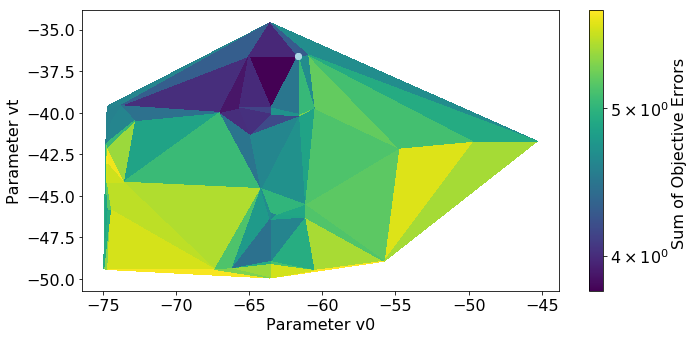

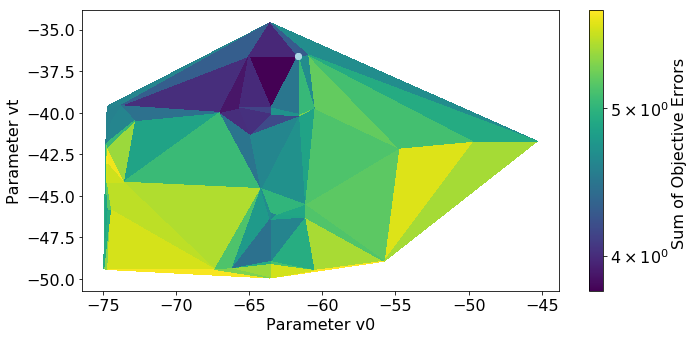

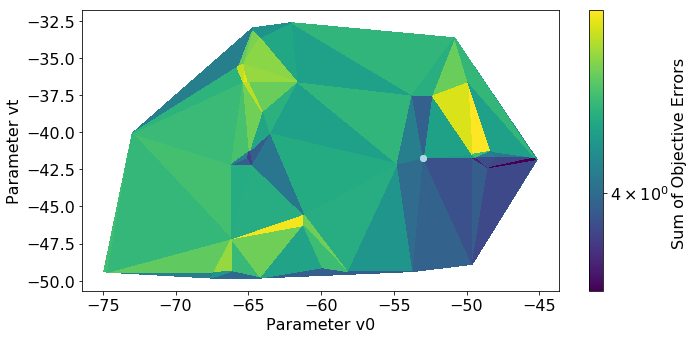

In [11]:

for index, val in enumerate(pipe_results.values()):
    td = val['td_py']
    history = val['history']

    plot_surface('v0','vt',td,history)
    

/opt/conda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


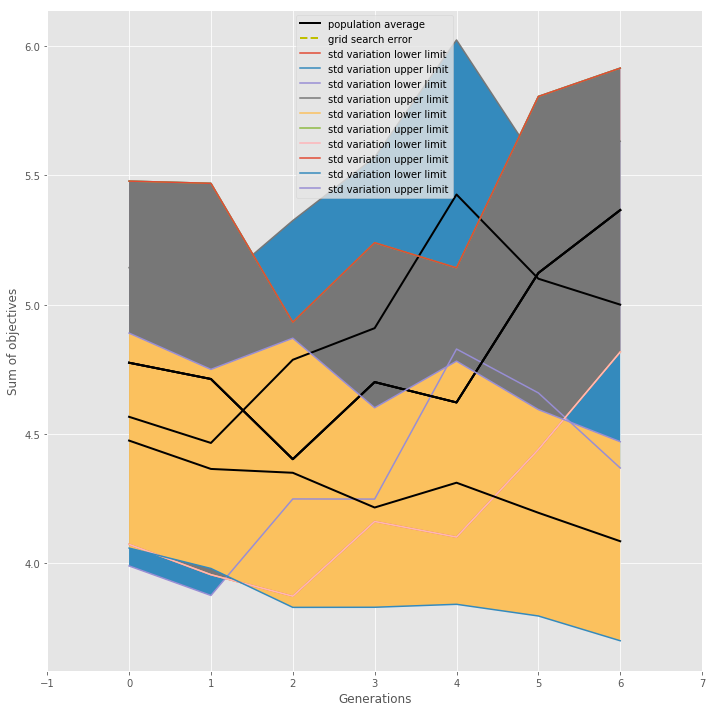

In [12]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
for index, val in enumerate(pipe_results.values()):
    
    log = val['log']
    gen_numbers =[ i for i in range(0,len(log.select('gen'))) ]
    hof = val['hof_py']
    mean = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('avg')])
    std = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('std')])
    minimum = np.array([ np.sqrt(np.mean(np.square(i))) for i in log.select('min')])
    best_line = np.array([ np.sqrt(np.mean(np.square(list(p.fitness.values))))  for p in hof])
    blg = [ best_line[h] for i, h in enumerate(gen_numbers) ]



    stdminus = mean - std
    stdplus = mean + std
    try:
        assert len(gen_numbers) == len(stdminus) == len(stdplus)
    except:
        pass

    axes.plot(
        gen_numbers,
        mean,
        color='black',
        linewidth=2,
        label='population average')
    axes.fill_between(gen_numbers, stdminus, stdplus)
    axes.plot(gen_numbers, blg,'y--', linewidth=2,  label='grid search error')
    #axes.plot(gen_numbers, bl, 'go', linewidth=2, label='hall of fame error')

    axes.plot(gen_numbers, stdminus, label='std variation lower limit')
    axes.plot(gen_numbers, stdplus, label='std variation upper limit')

    axes.set_xlim(np.min(gen_numbers) - 1, np.max(gen_numbers) + 1)
    axes.set_xlabel('Generations')
    axes.set_ylabel('Sum of objectives')
    axes.legend()
    fig.tight_layout()
    fig.show()


# Comment on plot
The plot shows the mean error value of the population as the GA evolves it's population. The red interval at any instant is the standard deviation of the error. The fact that the mean GA error is able to have a net upwards trajectory, after experiencing a temporary downwards trajectory, demonstrates that the GA retains a drive to explore, and is resiliant against being stuck in a local minima. Also in the above plot population variance in error stays remarkably constant, in this way BluePyOpts selection criteria SELIBEA contrasts with DEAPs native selection strategy NSGA2

In [ ]:
if USE_CACHED_GS:
    import pickle
    # shelve cache 
    first_third = pickle.load(open('/home/jovyan/neuronunit/neuronunit/unit_test/grid_dump_first_3rd.p','rb'))
    second_third = pickle.load(open('/home/jovyan/neuronunit/neuronunit/unit_test/grid_dump_second_3rd.p','rb'))
    final_third = pickle.load(open('/home/jovyan/neuronunit/neuronunit/unit_test/grid_dump_final_3rd.p','rb'))

    second_third.extend(first_third)
    second_third.extend(final_third)
    dtcpopg = second_third

else:
    from neuronunit.optimization import exhaustive_search
    from neuronunit.optimization import get_neab
    from neuronunit.optimization import optimization_management

    import dask.bag as db
    grid_points = exhaustive_search.create_grid(npoints = npoints,nparams = nparams)
    b0 = db.from_sequence(grid_points, npartitions=8)
    dlist = list(db.map(optimization_management.update_dtc_pop,b0).compute())
    for d in dlist:
        d.model_path = get_neab.LEMS_MODEL_PATH
        d.LEMS_MODEL_PATH = get_neab.LEMS_MODEL_PATH
    # this is a big load on memory so divide it into thirds.

    dlist_first_third = dlist[0:int(len(dlist)/N)]
    dlist_second_third = dlist[int(len(dlist)/N):int(2*len(dlist)/N)]
    dlist_final_third = dlist[int(2*len(dlist)/N):-1]
    from neuronunit.optimization.exhaustive_search import dtc_to_rheo
    from neuronunit.optimization.nsga_parallel import nunit_evaluate


    def compute_chunk(dlist_half):
        dlist_half = list(map(dtc_to_rheo,dlist_half))
        dlist_half = (nunit_evaluate,dlist_half)
        return dlist_half

    dlist_first_3rd = compute_chunk(dlist_first_third)
    import pickle
    with open('grid_dump_first_3rd.p','wb') as f:
       pickle.dump(dlist_first_3rd,f)
    # Garbage collect a big memory burden.
    dlist_first_3rd = None
    dlist_second_3rd = compute_chunk(dlist_second_third)

    with open('grid_dump_second_3rd.p','wb') as f:
       pickle.dump(dlist_second_3rd,f)
    # Garbage collect a big memory burden.
    dlist_second_3rd = None

    dlist_final_3rd = compute_chunk(dlist_final_third)
    with open('grid_dump_final_3rd.p','wb') as f:
       pickle.dump(dlist_final_3rd,f)
    # Garbage collect a big memory burden.
    dlist_final_3rd = None
    first_third = pickle.load(open('grid_dump_first_3rd.p','rb'))
    second_third = pickle.load(open('grid_dump_second_3rd.p','rb'))
    final_third = pickle.load(open('grid_dump_final_3rd.p','rb'))

    second_third.extend(first_third)
    second_third.extend(final_third)
    dtcpopg = second_third

    


In [ ]:
dtcpopg = [ dtc for dtc in dtcpopg if not None in (dtc.scores.values()) ]
dtcpopg = [ (dtc,sum(list(dtc.scores.values()))) for dtc in dtcpopg ]


sorted_grid = sorted(dtcpopg,key=lambda x:x[1])
sorted_grid = [dtc[0] for dtc in sorted_grid]
#print(sorted_grid)
mini = dtcpopg[0][1]
maxi = dtcpopg[-1][1]
minimagr = sorted_grid[0]
minimagr_dtc = sorted_grid[0]
minimagr_dtc_1 = sorted_grid[1]
minimagr_dtc_2 = sorted_grid[2]
from neuronunit.optimization.exhaustive_search import create_refined_grid
refined_grid = create_refined_grid(minimagr_dtc, minimagr_dtc_1,minimagr_dtc_2)


In [ ]:
print(td)
def pop2dtc(pop1,DO,td):
    '''
    This function takes the DEAP population data type, and converts it to a more convenient
    data transport object, which can more readily be used in plotting functions.
    This a wasteful, recompute, which is in part necessitated because
    deaps pareto front object, only returns gene individual objects (elements of population)
    '''
    from neuronunit.optimization import nsga_parallel
    DO.td = td
    assert DO.td == td
    return_package = nsga_parallel.update_pop(pop1,td);
    dtc_pop = []
    for i,r in enumerate(return_package):
        dtc_pop.append(r[0])
        dtc_pop[i].error = None
        dtc_pop[i].error = np.sqrt(np.mean(np.square(list(pop1[i].fitness.values))))
    sorted_list  = sorted([(dtc,dtc.error) for dtc in dtc_pop],key=lambda x:x[1])
    dtc_pop = [dtc[0] for dtc in sorted_list]
    print(dtc_pop,sorted_list)
    return dtc_pop

DO.td = td
print(hof[0])
print(len(hof))
dtc_pop = pop2dtc(hof[0:-1],DO,td)

miniga = dtc_pop[0].error
maxiga = dtc_pop[-1].error
maximaga = dtc_pop[-1]
minimaga = dtc_pop[0]

CACHE_PF = False

In [ ]:

if CACHE_PF == False:
    h = list(history.genealogy_history.values())
    evaluated_history = []
    for i in h:
        if hasattr(i,'rheobase'):
            i.error = None
            i.error = np.sqrt(np.mean(np.square(list(i.fitness.values))))
            evaluated_history.append(i)
    sorted_list  = sorted([(i,i.error) for i in evaluated_history ],key=lambda x:x[1])

    with open('pf_dump.p','wb') as f:
       pickle.dump([ sorted_list, evaluated_history ],f)
else: 
     
     unpack = pickle.load(open('pf_dump.p','rb'))
     print(unpack)
     sorted_list_pf = unpack[0]
     pareto_dtc = unpack[1] 

minimaga_ind = sorted_list[0][0]
maximaga_ind = sorted_list[-1][0]
miniga = sorted_list[0][1]
maxiga = sorted_list[-1][1]


In [ ]:
import pandas as pd

print(miniga)
print(maxiga)
print(minimaga_ind.fitness.values)
print(maximaga_ind.fitness.values)
print(len(minimaga_ind.fitness.values))
print(dtcpopg[0][0].rheobase)
print(dtcpopg[0][0].scores)
print(sorted_list[-1][0].rheobase)
print(sorted_list[-1][0].fitness.values)



In [ ]:
def use_dtc_to_plotting(dtcpop,minimagr):
    from neuronunit.capabilities import spike_functions
    import matplotlib.pyplot as plt
    import numpy as np
    plt.clf()
    plt.style.use('ggplot')
    fig, axes = plt.subplots(figsize=(10, 10), facecolor='white')
    stored_min = []
    stored_max = []
    for dtc in dtcpop[1:-1]:
        plt.plot(dtc.tvec, dtc.vm0,linewidth=3.5, color='grey')
        stored_min.append(np.min(dtc.vm0))
        stored_max.append(np.max(dtc.vm0))
        
    from neuronunit.models.reduced import ReducedModel
    from neuronunit.optimization.get_neab import tests as T
    from neuronunit.optimization import get_neab
    from neuronunit.optimization import evaluate_as_module
    from neuronunit.optimization.evaluate_as_module import pre_format
    model = ReducedModel(get_neab.LEMS_MODEL_PATH,name=str('vanilla'),backend='NEURON')
    import neuron
    model._backend.reset_neuron(neuron)
    model.set_attrs(minimagr.attrs)
    model.rheobase = minimagr.rheobase['value']
    minimagr = pre_format(minimagr)
    parameter_list = list(minimagr.vtest.values())
    model.inject_square_current(parameter_list[0])
    model._backend.local_run()
    assert model.get_spike_count() == 1
    print(model.get_spike_count(),bool(model.get_spike_count() == 1))
    brute_best = list(model.results['vm'])

    plt.plot(dtcpop[0].tvec, brute_best,linewidth=1, color='blue',label='best candidate via grid')#+str(mini.scores))
    plt.plot(dtcpop[0].tvec,dtcpop[0].vm0,linewidth=1, color='red',label='best candidate via GA')#+str(miniga.scores))
    plt.legend()
    plt.ylabel('$V_{m}$ mV')
    plt.xlabel('ms')
    plt.show()
from neuronunit import plottools
from neuronunit.plottools import dtc_to_plotting

CACHE_PLOTTING = False
if CACHE_PLOTTING == False:
    dtc_pop = dview.map_sync(dtc_to_plotting,dtc_pop )
    with open('plotting_dump.p','wb') as f:
       pickle.dump(dtc_pop,f)
else: 
     dtc_pop  = pickle.load(open('plotting_dump.p','rb'))

use_dtc_to_plotting(dtc_pop,minimagr_dtc)
            

# Comment on plot
There is good agreement between traces produced by the best candidate found by Genetic Algorithm, and exhaustive grid search.

In [ ]:
import pandas as pd

print(dtc_pop[0].scores)
print(minimagr_dtc.scores)
print(sum(list(dtc_pop[0].scores.values())))
print(sum(list(minimagr_dtc.scores.values())))
miniga = sum(list(dtc_pop[0].scores.values()))
print(miniga)


# Quantize distance between minimimum error and maximum error.
This step will allow the GA's performance to be located within or below the range of error found by grid search.


In [ ]:
print(maxi)
print(mini)
print(miniga)
quantize_distance = list(np.linspace(mini,maxi,10))

# check that the nsga error is in the bottom 1/5th of the entire error range.
print('Report: ')
print("Success" if bool(miniga < quantize_distance[0]) else "Failure")
print("The nsga error %f is in the bottom 1/5th of the entire error range" % miniga)
print("Minimum = %f; 20th percentile = %f; Maximum = %f" % (mini,quantize_distance[0],maxi))

The code below reports on the differences between between attributes of best models found via grid versus attributes of best models found via GA search:


In [ ]:
import pandas as pd

from neuronunit.optimization import evaluate_as_module as eam
NSGAO = NSGA(0.85)
NSGAO.setnparams(nparams=nparams,provided_keys=provided_keys)
#td = eam.get_trans_dict(NSGAO.subset)
#print(td)
td = { v:k for k,v in enumerate(td) }
from neuronunit.optimization import model_parameters as modelp
mp = modelp.model_params
#minimaga = pareto_dtc[0]
for k,v in minimagr_dtc.attrs.items():
    #hvgrid = np.linspace(np.min(mp[k]),np.max(mp[k]),10)
    dimension_length = np.max(mp[k]) - np.min(mp[k])
    solution_distance_in_1D = np.abs(float(hof[0][td[k]]))-np.abs(float(v))
        
    #solution_distance_in_1D = np.abs(float(minimaga.attrs[k]))-np.abs(float(v))
    relative_distance = dimension_length/solution_distance_in_1D
    print('the difference between brute force candidates model parameters and the GA\'s model parameters:')
    print(float(hof[0][td[k]])-float(v),hof[0][td[k]],v,k)
    print('the relative distance scaled by the length of the parameter dimension of interest:')
    print(relative_distance)

    
    

In [ ]:

print('the difference between the bf error and the GA\'s error:')
print('grid search:')
from numpy import square, mean, sqrt
rmsg = sqrt(mean(square(list(minimagr_dtc.scores.values()))))
print(rmsg)
print('ga:')
rmsga = sqrt(mean(square(list(dtc_pop[0].scores.values()))))
print(rmsga)
print('Hall of Fame front')
print(sqrt(mean(square(list(hof[0].fitness.values)))))
print(miniga)


If any time is left over, may as well compute a more accurate grid, to better quantify GA performance in the future.

In [ ]:
from neuronunit.optimization import get_neab
#fi_basket = {'nlex_id':'NLXCELL:100201'}
neuron = {'nlex_id': 'nifext_50'} 

error_criterion, inh_observations = get_neab.get_neuron_criteria(fi_basket)
print(error_criterion)

from bluepyopt.deapext.optimisations import DEAPOptimisation

DO = DEAPOptimisation(error_criterion=error_criterion)
DO.setnparams(nparams = nparams, provided_keys = provided_keys)
pop, hof, log, history, td, gen_vs_hof = DO.run(offspring_size = MU, max_ngen = NGEN, cp_frequency=4,cp_filename='checkpointedGA.p')
with open('ga_dump.p','wb') as f:
   pickle.dump([pop, log, history, hof, td],f)

In [ ]:
# Layer V pyramidal cell
